<a href="https://colab.research.google.com/github/injoon-pij/dlnlp-learning/blob/main/dlnlp_subword_tokenizer_bpe.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

* Subword segmenation
 * 하나의 단어는 더 작은 단위의 의미있는 여러 서브워드들(Ex) birthplace = birth + place)의 조합으로 구성된 경우가 많기 때문에, 하나의 단어를 여러 서브워드로 분리해서 단어를 인코딩 및 임베딩하겠다는 의도를 가진 전처리 작업
 * 이를 통해 OOV나 희귀 단어, 신조어와 같은 문제를 완화시킬 수 있음.

# 1) Byte Pair Encoding

* 1994년에 제안된 데이터 압축 알고리즘임
* 후에 자연어 처리의 서브워드 분리 알고리즘으로 응용됨

__[알고리즘 작동방법 예시]__

아래와 같은 문자열이 주어졌을 때, BPE를 수행하고자 할때, 

```
aaabdaaabac
```

BPE는 기본적으로 연속적으로 가장 많이 등장한 글자쌍(subwords)을 찾아서 하나의 글자로 병합하는 방식을 수행함

위의 문자열에서 가장 자주 등장하고 있는 글자(바이트) 쌍은 'aa'이므로 이 바이트 쌍을 하나의 바이트 'Z'로 치환하면 아래와 같아짐

```
ZabdZabac
Z=aa
```

같은 방식으로 치환된 문자열에서 가장 많이 등장하고 있는 바이트 쌍 'ab'를 'Y'로 치환하면 아래와 같음

```
ZYdZYac
Y=ab
Z=aa
```

위 과정을 한번 더 반복하면 아래와 같아지고 더이상 병합할 바이트 쌍이 존재하지 않아 아래의 결과를 최종 결과로 하여 BPE가 종료됨

```
XdXac
X=ZY
Y=ab
Z=aa
```

## 1.1 BPE in NLP

[논문 다운로드](https://arxiv.org/pdf/1508.07909.pdf)

* 글자(charcter) 단위에서 점차적으로 단어 집합을 만들어 내는 Bottom up 방식의 접근을 사용
* 훈련 데이터에 있는 단어들을 모든 글자(chracters) 또는 유니코드(unicode) 단위로 단어 집합을 만들고, 가장 많이 등장하는 유니그램을 하나의 유니그램으로 통합

__[자연어 처리에서의 BPE 알고리즘 적용 예시]__

* BPE는 알고리즘의 동작을 몇 회 반복(iteration)할 것인지를 사용자가 정함
* 여기서는 총 10회를 수행한다고 가정

```
# dictionary
l o w : 5,  l o w e r : 2,  n e w e s t : 6,  w i d e s t : 3
```

```
# vocabulary
l, o, w, e, r, n, w, s, t, i, d
```

__[iter = 1 : 빈도수가 9로 가장 높은 (e, s)의 쌍을 es로 통합]__

```
# dictionary update!
l o w : 5,
l o w e r : 2,
n e w es t : 6,
w i d es t : 3
```

```
# vocabulary update!
l, o, w, e, r, n, w, s, t, i, d, es
```

__[iter = 2 : 빈도수가 9로 가장 높은 (es, t)의 쌍을 est로 통합]__

```
# dictionary update!
l o w : 5,
l o w e r : 2,
n e w est : 6,
w i d est : 3
```

```
# vocabulary update!
l, o, w, e, r, n, w, s, t, i, d, es, est
```

__[iter = 3 : 빈도수가 7로 가장 높은 (l, o)의 쌍을 lo로 통합]__

```
# dictionary update!
lo w : 5,
lo w e r : 2,
n e w est : 6,
w i d est : 3
```

```
# vocabulary update!
l, o, w, e, r, n, w, s, t, i, d, es, est, lo
```

위와 같은 과정을 반복하여 10회 반복까지 완료하면 dictionary와 vocabulary 결과는 아래와 같음

```
# dictionary update!
low : 5,
low e r : 2,
newest : 6,
widest : 3
```

```
# vocabulary update!
l, o, w, e, r, n, w, s, t, i, d, es, est, lo, low, ne, new, newest, wi, wid, widest
```

* 'lowest'라는 새로운 단어가 등장한다면, 기존 자연어처리에서는 OOV에 해당되는 단어가 되었겠지만 BPE 알고리즘을 사용한 위의 단어 집합에서는 더이상 'lowest'는 OOV가 아니게 됨
* 기계는 우선 'lowest'를 전부 글자 단위('l, o, w, e, s, t')로 분할하고, 위의 단어 집합을 참고로 하여 'low'와 'est'를 찾아냄
 * 즉, 'lowest'를 'low'와 'est' 두 단어로 인코딩함
 * 이 두 단어는 둘 다 단어 집합에 있는 단어이므로 OOV가 아니게 되는 것임

__[BPE 알고리즘 동작 과정 시각화]__

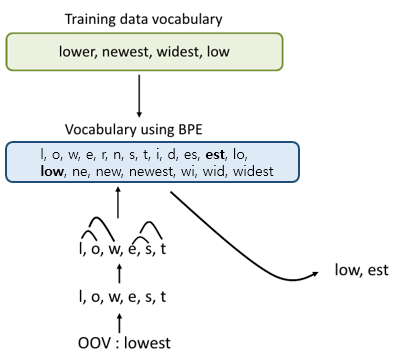

## 1.2 Coding 1.1's BPE Algorithm

In [1]:
import re, collections
from IPython.display import display, Markdown, Latex

In [2]:
# BPE 수행 횟수
num_merges = 10

In [3]:
dictionary = {'l o w </w>' : 5,
              'l o w e r </w>' : 2,
              'n e w e s t </w>':6,
              'w i d e s t </w>':3
              }

In [4]:
# 유니그램의 pair들의 빈도수를 카운트
def get_stats(dictionary):
    pairs = collections.defaultdict(int)
    for word, freq in dictionary.items():
        symbols = word.split()
        for i in range(len(symbols)-1):
            pairs[symbols[i],symbols[i+1]] += freq
    print('현재 pair들의 빈도수 :', dict(pairs))
    return pairs

# 빈도수가 가장 높은 pair를 통합한 형태를 딕셔너리에 업데이트
def merge_dictionary(pair, v_in):
    v_out = {}
    bigram = re.escape(' '.join(pair))
    p = re.compile(bigram)
    # p = re.compile(r'(?<!\S)' + bigram + r'(?!\S)')
    for word in v_in:
        w_out = p.sub(''.join(pair), word)
        v_out[w_out] = v_in[word]
    return v_out

* ```pairs = collections.defaultdict(int)```
 * ```collections.defaultdict(default_factory = None ...)```
   * defaultdict은 key값이 없을 경우 미리 지정해 놓은 초기(default)값을 반환하는 dictionary임
   * default_factory 는 defaultdict의 초기값을 지정하는 인자임
   * int로 초기값을 지정한 경우, key값이 없는 경우 모두 0으로 초기값이 설정됨

* ```bigram = re.escape(' '.join(pair))```
 * ```re.escape(pattern)```
   * Return string with all non-alphanumerics backslashed
   * ```re.escape('e s')``` => ```'e\ s'```

* ```p = re.compile(r'(?<!\S)' + bigram + r'(?!\S)')```
 * ```r'(?<!\S)' + bigram + r'(?!\S)'```
   * ```bigram``` 앞뒤로 ```\S```(공백문자가 아닌 문자)가 오면 안되는 환경 조건이 추가된 pattern
   * 'Negative lookbehind': ```(?<!    )``` which is saying __"What's before this is not..."__
   * ```r'(?<!\S)' + bigram``` : What's before ```bigram``` is not ```\S``` 

* ```p.sub(''.join(pair), word)```
 * ```re.sub(pattern, replace, string)```
   * 주어진 string 전체에서 pattern과 일치하는 모든 것을 replace로 교체하고, 결과를 str 타입으로 반환
   * 주어진 string인 ```word```에서 pattern ```p```와 일치하는 부분을 ```''.join(pair)```로 변경함 

In [5]:
bpe_codes = {}
bpe_codes_reverse = {}

for i in range(num_merges):
    display(Markdown("### Iteration {}".format(i + 1)))
    pairs = get_stats(dictionary)
    best = max(pairs, key=pairs.get)
    dictionary = merge_dictionary(best, dictionary)

    bpe_codes[best] = i
    bpe_codes_reverse[best[0] + best[1]] = best

    print("new merge: {}".format(best))
    print("dictionary: {}".format(dictionary))

### Iteration 1

현재 pair들의 빈도수 : {('l', 'o'): 7, ('o', 'w'): 7, ('w', '</w>'): 5, ('w', 'e'): 8, ('e', 'r'): 2, ('r', '</w>'): 2, ('n', 'e'): 6, ('e', 'w'): 6, ('e', 's'): 9, ('s', 't'): 9, ('t', '</w>'): 9, ('w', 'i'): 3, ('i', 'd'): 3, ('d', 'e'): 3}
new merge: ('e', 's')
dictionary: {'l o w </w>': 5, 'l o w e r </w>': 2, 'n e w es t </w>': 6, 'w i d es t </w>': 3}


### Iteration 2

현재 pair들의 빈도수 : {('l', 'o'): 7, ('o', 'w'): 7, ('w', '</w>'): 5, ('w', 'e'): 2, ('e', 'r'): 2, ('r', '</w>'): 2, ('n', 'e'): 6, ('e', 'w'): 6, ('w', 'es'): 6, ('es', 't'): 9, ('t', '</w>'): 9, ('w', 'i'): 3, ('i', 'd'): 3, ('d', 'es'): 3}
new merge: ('es', 't')
dictionary: {'l o w </w>': 5, 'l o w e r </w>': 2, 'n e w est </w>': 6, 'w i d est </w>': 3}


### Iteration 3

현재 pair들의 빈도수 : {('l', 'o'): 7, ('o', 'w'): 7, ('w', '</w>'): 5, ('w', 'e'): 2, ('e', 'r'): 2, ('r', '</w>'): 2, ('n', 'e'): 6, ('e', 'w'): 6, ('w', 'est'): 6, ('est', '</w>'): 9, ('w', 'i'): 3, ('i', 'd'): 3, ('d', 'est'): 3}
new merge: ('est', '</w>')
dictionary: {'l o w </w>': 5, 'l o w e r </w>': 2, 'n e w est</w>': 6, 'w i d est</w>': 3}


### Iteration 4

현재 pair들의 빈도수 : {('l', 'o'): 7, ('o', 'w'): 7, ('w', '</w>'): 5, ('w', 'e'): 2, ('e', 'r'): 2, ('r', '</w>'): 2, ('n', 'e'): 6, ('e', 'w'): 6, ('w', 'est</w>'): 6, ('w', 'i'): 3, ('i', 'd'): 3, ('d', 'est</w>'): 3}
new merge: ('l', 'o')
dictionary: {'lo w </w>': 5, 'lo w e r </w>': 2, 'n e w est</w>': 6, 'w i d est</w>': 3}


### Iteration 5

현재 pair들의 빈도수 : {('lo', 'w'): 7, ('w', '</w>'): 5, ('w', 'e'): 2, ('e', 'r'): 2, ('r', '</w>'): 2, ('n', 'e'): 6, ('e', 'w'): 6, ('w', 'est</w>'): 6, ('w', 'i'): 3, ('i', 'd'): 3, ('d', 'est</w>'): 3}
new merge: ('lo', 'w')
dictionary: {'low </w>': 5, 'low e r </w>': 2, 'n e w est</w>': 6, 'w i d est</w>': 3}


### Iteration 6

현재 pair들의 빈도수 : {('low', '</w>'): 5, ('low', 'e'): 2, ('e', 'r'): 2, ('r', '</w>'): 2, ('n', 'e'): 6, ('e', 'w'): 6, ('w', 'est</w>'): 6, ('w', 'i'): 3, ('i', 'd'): 3, ('d', 'est</w>'): 3}
new merge: ('n', 'e')
dictionary: {'low </w>': 5, 'low e r </w>': 2, 'ne w est</w>': 6, 'w i d est</w>': 3}


### Iteration 7

현재 pair들의 빈도수 : {('low', '</w>'): 5, ('low', 'e'): 2, ('e', 'r'): 2, ('r', '</w>'): 2, ('ne', 'w'): 6, ('w', 'est</w>'): 6, ('w', 'i'): 3, ('i', 'd'): 3, ('d', 'est</w>'): 3}
new merge: ('ne', 'w')
dictionary: {'low </w>': 5, 'low e r </w>': 2, 'new est</w>': 6, 'w i d est</w>': 3}


### Iteration 8

현재 pair들의 빈도수 : {('low', '</w>'): 5, ('low', 'e'): 2, ('e', 'r'): 2, ('r', '</w>'): 2, ('new', 'est</w>'): 6, ('w', 'i'): 3, ('i', 'd'): 3, ('d', 'est</w>'): 3}
new merge: ('new', 'est</w>')
dictionary: {'low </w>': 5, 'low e r </w>': 2, 'newest</w>': 6, 'w i d est</w>': 3}


### Iteration 9

현재 pair들의 빈도수 : {('low', '</w>'): 5, ('low', 'e'): 2, ('e', 'r'): 2, ('r', '</w>'): 2, ('w', 'i'): 3, ('i', 'd'): 3, ('d', 'est</w>'): 3}
new merge: ('low', '</w>')
dictionary: {'low</w>': 5, 'low e r </w>': 2, 'newest</w>': 6, 'w i d est</w>': 3}


### Iteration 10

현재 pair들의 빈도수 : {('low', 'e'): 2, ('e', 'r'): 2, ('r', '</w>'): 2, ('w', 'i'): 3, ('i', 'd'): 3, ('d', 'est</w>'): 3}
new merge: ('w', 'i')
dictionary: {'low</w>': 5, 'low e r </w>': 2, 'newest</w>': 6, 'wi d est</w>': 3}


In [6]:
print(bpe_codes)

{('e', 's'): 0, ('es', 't'): 1, ('est', '</w>'): 2, ('l', 'o'): 3, ('lo', 'w'): 4, ('n', 'e'): 5, ('ne', 'w'): 6, ('new', 'est</w>'): 7, ('low', '</w>'): 8, ('w', 'i'): 9}


In [7]:
print(bpe_codes_reverse)

{'es': ('e', 's'), 'est': ('es', 't'), 'est</w>': ('est', '</w>'), 'lo': ('l', 'o'), 'low': ('lo', 'w'), 'ne': ('n', 'e'), 'new': ('ne', 'w'), 'newest</w>': ('new', 'est</w>'), 'low</w>': ('low', '</w>'), 'wi': ('w', 'i')}


### 1.2.1 Dealing with OOV

In [34]:
# subword pair (prev_char, char) set 생성
def get_pairs(word):
    pairs = set()
    prev_char = word[0]
    for char in word[1:]:
        pairs.add((prev_char, char))
        prev_char = char
    return pairs

In [35]:
# BPE Algorithm
def encode(orig):
    word = tuple(orig) + ('</w>',)
    # 마크다운 문법에서 <> 안의 내용은 표시되지 않으므로 display 결과에 </w>는 표시되지 않음
    # <tt>는 글꼴, __는 bold체
    display(Markdown("__word split into characters:__ <tt>{}</tt>".format(word)))

    # subword pair set 생성
    pairs = get_pairs(word)    

    # pair가 빈 set일 경우 입력값 반환
    if not pairs:
        return orig

    # BPE 알고리즘 반복 적용
    iteration = 0
    while True:
        iteration += 1
        display(Markdown("__Iteration {}:__".format(iteration)))

        print("bigrams in the word: {}".format(pairs))

        # 훈련 과정에서 얻은 bpe_code에서 결합 우선순위가 가장 먼저 였던 bigram 선택  
        bigram = min(pairs, key = lambda pair: bpe_codes.get(pair, float('inf')))
        print("candidate for merging: {}".format(bigram))

        # 더이상 bpe_code에 해당되는 bigram이 없을 시 알고리즘 종료
        if bigram not in bpe_codes:
            display(Markdown("__Candidate not in BPE merges, algorithm stops.__"))
            break

        first, second = bigram
        new_word = []

        # 목표 subword pair을 결합한 형태로 새롭게 저장하기 위한 과정
        # i는 검색 시작 인덱스 위치
        i = 0
        while i < len(word): # 검색 시작 인덱스가 단어 범위를 벗어나기 전까지 반복
            try:
                j = word.index(first, i) # ValueError 발생 가능 부분
                new_word.extend(word[i:j]) # i부터 검색한 first subword의 인덱스 전까지의 subword들 저장 
                i = j
            
            # ValueError 발생, 즉 i번째 인덱스부터 검색했는데 더이상 first에 해당되는 subword가 없을 때
            # 찾고자 하는 bigram이 더이상 남아있지 않으므로 남은 부분은 결합없이 저장 후 검색 종료 
            except:
                new_word.extend(word[i:])
                break

            # 목표 bigram을 찾은 경우
            # i번째 인덱스 subword와 i+1번째 인덱스 subword를 결합하여 저장
            # 검색 시작 위치 두칸 뒤로 이동
            if word[i] == first and i < len(word)-1 and word[i+1] == second:
                new_word.append(first+second)
                i += 2
            
            # 검색된 인덱스의 subword가 뒤에 이어지는 subword와 함께 목표하는 bigram을 형성하지 않는 경우
            # 단어의 마지막 인덱스라 뒤에 subword가 존재하지 않거나, word[i+1] != second인 경우가 포함됨
            # 별도의 결합없이 i번째 인덱스 subword만 저장
            # 검색 시작 위치 한칸 뒤로 이동
            else:
                new_word.append(word[i])
                i += 1

        new_word = tuple(new_word)
        word = new_word # subword 결합 완료된 형태로 word 업데이트
        print("word after merging: {}".format(word))
        
        # word가 입력 단어와 같아졌을 시에 bpe 알고리즘 종료
        if len(word) == 1:
            break

        # 새롭게 만들어진 word(tuple)로 subword pair set 업데이트 후 알고리즘 재실행
        else:
            pairs = get_pairs(word)

    # 특별 토큰인 </w>는 출력 X
    if word[-1] == '</w>':
        word = word[:-1]
    elif word[-1].endswith('</w>'):
        word = word[:-1] + (word[-1].replace('</w>',''),)

    return word

* ```bigram = min(pairs, key = lambda pair: bpe_codes.get(pair, float('inf')))```
 * bpe_code 딕셔너리에서 subword pair를 검색하여, value값이 가장 낮은, 즉 훈련과정에서 결합 우선 순위가 가장 먼저였던 bigram을 선택
 * ```bpe_codes.get(pair, float('inf'))```
   * 만약 subword pair가 딕셔너리에 존재하지 않는 경우, value 값은 float('inf'), 무한대로 지정
   * ```dictionary.get(keyname, value)```
   * ```value``` : Optional. A value to return if the specified key does not exist. (Default value : ```None```)

* ```j = word.index(first, i)```
 * word에서 first를 i번째 인덱스부터 검색
 * ```
 ('a','b','c','a','b','c').index('b', 0)
 >>> 1
```
 * ```
 ('a','b','c','a','b','c').index('b', 1)
 >>> 1
```
 * ```
 ('a','b','c','a','b','c').index('b', 2)
 >>> 4
```
 * ```
 ('a','b','c','a','b','c').index('b', 5)
 >>> ValueError: tuple.index(x): x not in tuple
```

In [56]:
encode('newest')

__word split into characters:__ <tt>('n', 'e', 'w', 'e', 's', 't', '</w>')</tt>

__Iteration 1:__

bigrams in the word: {('t', '</w>'), ('e', 'w'), ('n', 'e'), ('w', 'e'), ('s', 't'), ('e', 's')}
candidate for merging: ('e', 's')
word after merging: ('n', 'e', 'w', 'es', 't', '</w>')


__Iteration 2:__

bigrams in the word: {('t', '</w>'), ('e', 'w'), ('n', 'e'), ('es', 't'), ('w', 'es')}
candidate for merging: ('es', 't')
word after merging: ('n', 'e', 'w', 'est', '</w>')


__Iteration 3:__

bigrams in the word: {('w', 'est'), ('est', '</w>'), ('e', 'w'), ('n', 'e')}
candidate for merging: ('est', '</w>')
word after merging: ('n', 'e', 'w', 'est</w>')


__Iteration 4:__

bigrams in the word: {('e', 'w'), ('n', 'e'), ('w', 'est</w>')}
candidate for merging: ('n', 'e')
word after merging: ('ne', 'w', 'est</w>')


__Iteration 5:__

bigrams in the word: {('ne', 'w'), ('w', 'est</w>')}
candidate for merging: ('ne', 'w')
word after merging: ('new', 'est</w>')


__Iteration 6:__

bigrams in the word: {('new', 'est</w>')}
candidate for merging: ('new', 'est</w>')
word after merging: ('newest</w>',)


('newest',)

In [36]:
encode("loki")

__word split into characters:__ <tt>('l', 'o', 'k', 'i', '</w>')</tt>

__Iteration 1:__

bigrams in the word: {('o', 'k'), ('i', '</w>'), ('k', 'i'), ('l', 'o')}
candidate for merging: ('l', 'o')
word after merging: ('lo', 'k', 'i', '</w>')


__Iteration 2:__

bigrams in the word: {('k', 'i'), ('i', '</w>'), ('lo', 'k')}
candidate for merging: ('k', 'i')


__Candidate not in BPE merges, algorithm stops.__

('lo', 'k', 'i')

In [80]:
encode("lowing")

__word split into characters:__ <tt>('l', 'o', 'w', 'i', 'n', 'g', '</w>')</tt>

__Iteration 1:__

bigrams in the word: {('n', 'g'), ('o', 'w'), ('i', 'n'), ('w', 'i'), ('l', 'o'), ('g', '</w>')}
candidate for merging: ('l', 'o')
word after merging: ('lo', 'w', 'i', 'n', 'g', '</w>')


__Iteration 2:__

bigrams in the word: {('n', 'g'), ('i', 'n'), ('w', 'i'), ('g', '</w>'), ('lo', 'w')}
candidate for merging: ('lo', 'w')
word after merging: ('low', 'i', 'n', 'g', '</w>')


__Iteration 3:__

bigrams in the word: {('n', 'g'), ('i', 'n'), ('g', '</w>'), ('low', 'i')}
candidate for merging: ('n', 'g')


__Candidate not in BPE merges, algorithm stops.__

('low', 'i', 'n', 'g')

In [81]:
encode("highing")

__word split into characters:__ <tt>('h', 'i', 'g', 'h', 'i', 'n', 'g', '</w>')</tt>

__Iteration 1:__

bigrams in the word: {('i', 'g'), ('n', 'g'), ('i', 'n'), ('g', '</w>'), ('g', 'h'), ('h', 'i')}
candidate for merging: ('i', 'g')


__Candidate not in BPE merges, algorithm stops.__

('h', 'i', 'g', 'h', 'i', 'n', 'g')

## 1.3 Wordpiece Model (WPM)

[논문](https://static.googleusercontent.com/media/research.google.com/ko//pubs/archive/37842.pdf)

[구글이 Wordpiece Model을 변형하여 번역기에 사용했다는 논문](https://arxiv.org/pdf/1609.08144.pdf)

* BPE의 변형 알고리즘
 * BPE가 빈도수에 기반하여 가장 많이 등장한 쌍을 병합하는 것과는 달리, 병합되었을 때 코퍼스의 우도(Likelihood)를 가장 높이는 쌍을 병합하는 알고리즘

* __WPM을 수행하기 이전의 문장__ : Jet makers feud over seat width with big orders at stake
* __WPM을 수행한 결과(wordpieces)__ : _J et _makers _fe ud _over _seat _width _with _big _orders _at _stake

 * WPM은 모든 단어의 맨 앞에 _를 붙이고, 단어는 서브 워드(subword)로 통계에 기반하여 띄어쓰기로 분리함
 * 언더바 _는 기존에 있던 띄어쓰기와 구분자 역할의 띄어쓰기를 구분하게 해주는 문장 복원을 위한 장치
   * WPM이 수행된 결과로부터 다시 수행 전의 결과로 돌리는 방법은 현재 있는 모든 띄어쓰기를 전부 제거하고, 언더바를 띄어쓰기로 바꾸면 됨

* 딥러닝 모델 BERT를 훈련하기 위해서 사용되기도 하였음

## 1.4 Unigram Language Model Tokenizer

[논문](https://arxiv.org/pdf/1804.10959.pdf)

* 각각의 서브워드들에 대해서 손실을 계산하고, 서브워드들을 측정된 손실의 정도로 정렬하여 최악의 영향을 주는 10~20%의 토큰을 제거함
 * 서브워드들의 손실이이란 해당 서브워드가 단어 집합에서 제거되었을 경우, 코퍼스의 우도(Likelihood)가 감소하는 정도를 말함
* 이 과정을 원하는 단어 집합의 크기에 도달할 때까지 반복 